In [2]:
# define relevants paths and load functions and libraries

%run Z:\\home\\shared\\Gaia\\Coliseum\\Delays\\paper_code\\Analysis\\helper_functions\\functions_analysis.py
    
data_path = 'paper_code\\Datasets\\' # your data path
saving_path = 'paper_code\\Figures_output\\' # your saving figures path


In [8]:
# import relevant datasets

# load the main dataset
file= ''.join([data_path,'neurons_datasets\\delay_tuning_dataset.mat'])
data_dict = mat73.loadmat(file)
DAT=data_dict['delay_tuning_dataset']

# check keys available
print(DAT.keys())

dict_keys(['AP_lim', 'ML_lim', 'all_boot_aud', 'all_boot_vis', 'animal_ID', 'binSize', 'coord3D', 'depth_lim', 'experiment_ID', 'modality', 'peaks', 'pvals', 'resp', 'spikes', 'trials', 'window_spikes'])


In [9]:
# Extract spatial coordinates

coord3D=DAT['coord3D']
coord3D_lab=['AP','depth_in_brain','ML']
animal_IDs = DAT['animal_ID']
experiment_IDs = DAT['experiment_ID']

AP_lim=DAT['AP_lim']
ML_lim=DAT['ML_lim']
depth_lim=DAT['depth_lim']

actual_lengthML = ML_lim[1] - ML_lim[0]
actual_lengthAP = AP_lim[1] - AP_lim[0]
actual_lengthdepth = depth_lim[1] - depth_lim[0]

# maybe it's better to take the actual length, so subtract the minimum of the range
ML_norm = coord3D[:,2] - ML_lim[0]
AP_norm = coord3D[:,0] - AP_lim[0]
depth_norm = coord3D[:,1] - depth_lim[0]

# invert the ML axis first
max_val = actual_lengthML
min_val = 0 
new_ML = np.array([max_val - val + min_val for val in ML_norm])
ML_norm = new_ML


In [15]:
# Spatial relationship of decoding accuracy for individual recordings - Fig 6A-B

# load accuracy of individual recordings
load_dir = ''.join([data_path,'decoder_datasets\\decoder_accuracy_single_rec_SVM.npy'])
accuracy_SVM= np.load(load_dir) 
accuracy_SVM = np.mean(accuracy_SVM,axis=1)

# get the mean ML and AP position ofr each recording session
experiment_ID = DAT['experiment_ID']
recs = np.unique(experiment_ID).astype(int)
mean_ML = np.zeros((accuracy_SVM.shape[0],1))
mean_AP = np.zeros((accuracy_SVM.shape[0],1))
for count, i in enumerate(recs):
    pos = np.argwhere(experiment_IDs == i)
    mean_ML[count] = np.nanmean(ML_norm[pos])
    mean_AP[count] = np.nanmean(AP_norm[pos])

val_min = 0 
val_max = np.round(np.nanmax(accuracy_SVM)).astype(int)
big_val_max = val_max

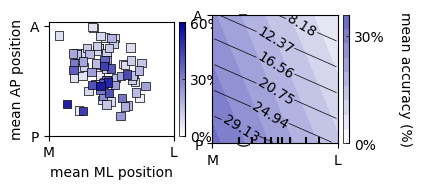

In [30]:
# Plot it 
fig, axs = plt.subplots(1, 2, figsize=(3,2))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.subplots_adjust(hspace=0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', [(1, 1, 1), '#000099'])

# Ensure both subplots have the same aspect ratio
for ax in axs:
    ax.set_aspect('equal', adjustable='box')
    
    
ax = axs[0]

# let's exclude the zero accuracy 
pos = np.argwhere(accuracy_SVM[:,0] == 0)

# Create a mask to exclude positions with zeros
mask = np.ones(accuracy_SVM[:,0].shape, dtype=bool)
mask[pos] = False

# Apply the mask to exclude zero positions
filtered_accuracy = accuracy_SVM[mask,0]
filtered_ML = mean_ML[mask,0]
filtered_AP = mean_AP[mask,0]

# also exclude Nans of filtered_ML
pos = np.argwhere(np.isnan(filtered_ML))
# Create a mask to exclude positions with zeros
mask = np.ones(filtered_ML.shape, dtype=bool)
mask[pos] = False

# Apply the mask to exclude zero positions
filtered_accuracy = filtered_accuracy[mask]
filtered_ML = filtered_ML[mask]
filtered_AP = filtered_AP[mask]

# let's plot them sorted 
# Combine data into a single array for easier sorting
data = np.rec.array((filtered_ML,filtered_AP,filtered_accuracy), 
                    dtype=[('filtered_ML', 'f8'), ('filtered_AP', 'f8'), ('filtered_accuracy', 'f8')])

# Sort by mean_results in ascending order
sorted_data = np.sort(data, order='filtered_accuracy')

# Extract the sorted values
sorted_mean_ML = sorted_data.filtered_ML
sorted_mean_AP = sorted_data.filtered_AP
sorted_mean_results = sorted_data.filtered_accuracy
scatter = ax.scatter(sorted_mean_ML, sorted_mean_AP, c=sorted_mean_results, marker='s',
                     vmin=val_min, vmax=val_max, cmap=cmap, edgecolors='black', linewidths=0.5)


# add label to colorbar
divider = make_axes_locatable(ax)
norm = LogNorm(vmin=val_min, vmax=val_max)

cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(scatter,cax=cax ,ticks=[val_min,val_max/2, val_max],  format='%d', norm=norm)
cbar.ax.set_yticklabels(['{}%'.format(val_min), '{:.0f}%'.format(val_max/2), '{}%'.format(val_max)])
cbar.set_label('mean accuracy (%)',rotation=-90,labelpad=20,fontsize=10)
cbar.ax.yaxis.set_ticks_position('right')
cbar.ax.yaxis.set_label_position('right')
cbar.ax.spines['right'].set_visible(True)
cbar.ax.tick_params(width=0.5, length=2, direction='in', which='both')
cbar.outline.set_linewidth(0.5)

ax.set_xlabel('mean ML position')
ax.set_ylabel('mean AP position')
ax.set_xticks([0,actual_lengthML],['M','L'])
ax.set_yticks([0,actual_lengthAP],['A','P'])

# Invert the y-axis
ax.invert_yaxis()
ax.set_aspect('equal', adjustable='box')

# plot the decoding gradient
Y = accuracy_SVM
X = np.concatenate((mean_ML,mean_AP),axis=1)
# get nans positions
nan_pos1 = np.argwhere(np.isnan(Y[:,0]))
nan_pos2 = np.argwhere(np.isnan(X[:,0]))
nan_pos = np.unique(np.concatenate((nan_pos1,nan_pos2),axis=0))
# Exclude NaN positions using boolean indexing
mask = np.ones(len(Y), dtype=bool)
mask[nan_pos] = False

# exclude the nan_pos
Y = Y[mask]
X = X[mask, :]
# let's try to invert the y axis
X[:,1] = actual_lengthAP - X[:,1]
# first fit the chosen model 
model = LinearRegression()
model.fit(X, Y)

this_ax = axs[1]
display_linear = PartialDependenceDisplay.from_estimator(
    model, X, [(0, 1)],
    grid_resolution=15,
    random_state=42, 
    percentiles=(0.01,0.99),
    contour_kw={'cmap': cmap},
    ax=this_ax
)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
ax.set_ylabel('')
ax.set_yticks([np.nanmin(X[:,1],axis=0),np.nanmax(X[:,1],axis=0)])
ax.set_yticklabels(['P','A'])
ax.set_xlabel('')
ax.set_xticks([np.nanmin(X[:,0],axis=0),np.nanmax(X[:,0],axis=0)])
ax.set_xticklabels(['M','L'])

# Compute grid points
x_min, x_max = np.nanmin(X[:, 0]), np.nanmax(X[:, 0])
y_min, y_max = np.nanmin(X[:, 1]), np.nanmax(X[:, 1])
grid_resolution = 15  # or any other value
x_values = np.linspace(x_min, x_max, grid_resolution)
y_values = np.linspace(y_min, y_max, grid_resolution)
x_mesh, y_mesh = np.meshgrid(x_values, y_values)

# Create contour plot
average_array = np.squeeze(display_linear.pd_results[0]['average'])
val_min = 0
val_max = big_val_max
contour_plot = ax.contourf(x_mesh, y_mesh, average_array, cmap=cmap, vmin=val_min, vmax=val_max)

# Create colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(contour_plot, cax=cax, ticks=[val_min,val_max/2, val_max],  format='%d', norm=norm)
cbar.ax.set_yticklabels(['{}%'.format(val_min), '{:.0f}%'.format(val_max/2), '{}%'.format(val_max)])
cbar.set_label('mean accuracy (%)',rotation=-90,labelpad=20,fontsize=10)
cbar.ax.yaxis.set_ticks_position('right')
cbar.ax.yaxis.set_label_position('right')
cbar.ax.spines['right'].set_visible(True)
cbar.ax.tick_params(width=0.5, length=2, direction='in', which='both')
cbar.outline.set_linewidth(0.5)

# define a saving directory and save it 
dir = ''.join([saving_path,'Figure6A_B.svg'])
fig.savefig(dir, dpi=300,format='svg',bbox_inches='tight', pad_inches=0)


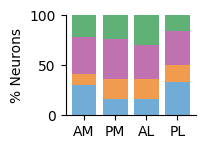

In [6]:
# Percentages of sensory neurons in bins - Fig 6C

n_neurons = 50
n_var = 2

# load the files
file = ''.join([data_path,f'decoder_datasets\\clf_2D_and_3D\\n_modalities_n{n_neurons}_{n_var}.npy'])
n_modalities = np.load(file)
n_tot = np.sum(n_modalities,axis=1)

vis_bins=n_modalities[:,1]
aud_bins=n_modalities[:,2]
aud_vis_bins=np.sum(n_modalities[:,3:],axis=1)

# these are delay neurons
file =''.join([data_path,f'decoder_datasets\\clf_2D_and_3D\\n_delay_n{n_neurons}_{n_var}.npy'])
n_delay = np.load(file).reshape(-1)

# subtract the delay neurons from the multisensory neurons
aud_vis_bins = aud_vis_bins - n_delay

# now you put them together in an array
all_values = np.zeros((n_modalities.shape[0],4))
all_values[:,0]=vis_bins
all_values[:,1]=aud_bins
all_values[:,2]=aud_vis_bins
all_values[:,3]=n_delay

# normalize so that each square adds up to 100
norm_values_modalities = np.zeros(all_values.shape)
for i in range(all_values.shape[0]):
    norm_values_modalities[i,:]=all_values[i,:]/np.sum(all_values[i,:])*100

fig, this_ax = plt.subplots(figsize=(1.3,1))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.subplots_adjust(hspace=0.5)

colors = sns.color_palette('YlGn', n_colors=11)
colors = ['#4D98CE','#EE8222','#AF4E9D',colors[7]]
stim = ['Visual', 'Auditory', 'Audiovisual','Delay']

x = ['AM', 'PM','AL','PL']

norm_values = norm_values_modalities
curr_values = norm_values[:4, :]
bottom = np.zeros(curr_values.shape[0])
for i in range(norm_values.shape[1]):
    this_ax.bar(x[:4], curr_values[:, i], bottom=bottom, label=stim[i],color = colors[i], alpha = 0.8)
    bottom += curr_values[:, i]

this_ax.spines['top'].set_visible(False)
this_ax.spines['right'].set_visible(False)
this_ax.set_ylim([0,100])
this_ax.set_yticks([0,50,100])
this_ax.set_ylabel('% Neurons',fontsize=10)

curr_values = norm_values[4:, :]
bottom = np.zeros(curr_values.shape[0])
for i in range(norm_values.shape[1]):
    this_ax.bar(x[4:], curr_values[:, i], bottom=bottom, label=stim[i],color = colors[i], alpha = 0.8)
    bottom += curr_values[:, i]
this_ax.spines['top'].set_visible(False)
this_ax.spines['right'].set_visible(False)

# define a saving directory and save it 
dir = ''.join([saving_path,'Figure6C.svg'])
fig.savefig(dir, dpi=300,format='svg',bbox_inches='tight', pad_inches=0)


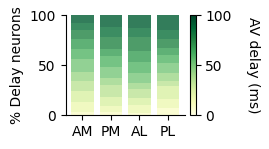

In [7]:
# Plot the types of delay present in the bins - Fig 6D

fig, this_ax = plt.subplots(figsize=(1.3,1))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.subplots_adjust(hspace=0.5)

# the fourth subplot: delay neurons distribution
file =''.join([data_path,f'decoder_datasets\\clf_2D_and_3D\\type_delay_n{n_neurons}_{n_var}.npy'])
type_delay = np.load(file)

norm_values = np.zeros(type_delay.shape)

# the first way of normalizing it is to have each square in the three modalities to add up to 100
for i in range(type_delay.shape[0]):
    norm_values[i,:]=type_delay[i,:]/np.sum(type_delay[i,:])*100

colors = sns.color_palette('YlGn', n_colors=11)
x = ['AM', 'PM','AL','PL']

curr_values = norm_values[:4, :]
bottom = np.zeros(curr_values.shape[0])
for i in range(norm_values.shape[1]):
    this_ax.bar(x[:4], curr_values[:, i], bottom=bottom, label=f'delay {i*10}',color = colors[i], alpha = 0.8)
    bottom += curr_values[:, i]
this_ax.spines['top'].set_visible(False)
this_ax.spines['right'].set_visible(False)

#this_ax.tick_params(axis='y', which='both', length=0)
this_ax.set_ylabel('% Delay neurons',fontsize=10)
this_ax.set_yticks([0,50,100])
this_ax.set_ylim([0,100])
sm = plt.cm.ScalarMappable(cmap='YlGn', norm=plt.Normalize(vmin=0, vmax=10))
divider = make_axes_locatable(this_ax)
norm = LogNorm(vmin=0, vmax=11)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(sm,cax=cax)
cbar.set_label('AV delay (ms)',rotation=-90,labelpad=20,fontsize=10)
cbar.set_ticks([0, 5, 10])
cbar.set_ticklabels([0, 50, 100])

# define a saving directory and save it 
dir = ''.join([saving_path,'Figure6D.svg'])
fig.savefig(dir, dpi=300,format='svg',bbox_inches='tight', pad_inches=0)


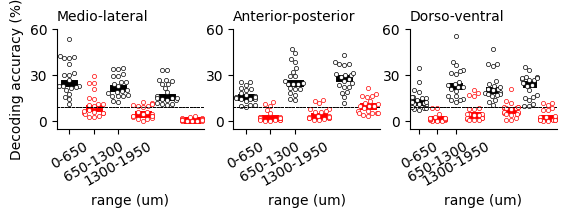

In [34]:
# Accuracy along axes for both observed and syntehtic linear SVM - Fig 6E
axes =['ML','AP','depth']

load_dir = ''.join([data_path,'decoder_datasets\\decoder_accuracy_axes_1D.npy'])
scores = np.load(load_dir)

load_dir = ''.join([data_path,'decoder_datasets\\decoder_accuracy_axes_1D_locations.npy'])
locs = np.load(load_dir)

fig, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(5,1))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.subplots_adjust(hspace=0.5)
n_delays = 11
chance_accuracy = 1/n_delays*100

for count,type_axis in enumerate(axes):
    
    if count ==0:
        this_ax = ax4
        this_ax.set_title('Medio-lateral',loc='left',fontsize=10)
        this_ax.set_ylabel('Decoding accuracy (%)',fontsize=10)
    elif count ==1:
        this_ax = ax5
        this_ax.set_title('Anterior-posterior',loc='left',fontsize=10)
    else:
        this_ax = ax6   
        this_ax.set_title('Dorso-ventral',loc='left',fontsize=10)

    # make the edge color black
    if type_axis == 'ML':
        these_scores = scores[:,:,:,:-1]
    elif type_axis == 'AP':
        these_scores = scores[:,:,:,:-1]
    else: 
        these_scores = scores
    
    these_scores = these_scores[count,:,:,:]
    
    meanLineWidth = 0.2

 
    # Plot the medians
    if count ==0:
        order = [0,3,1,4,2,5]
    elif count ==1:
        order = [0,3,1,4,2,5]
    else:
        order = [0,4,1,5,2,6,3,7]
        
    reshaped_scores = np.swapaxes(these_scores, 0, 1).reshape(20, -1)
    reordered_scores = reshaped_scores[:, order]
    
    num_locations = reordered_scores.shape[1]
    for loc in range(num_locations):
        curr_scores = reordered_scores[:, loc]
        med = np.median(curr_scores)
        
        color = 'k' if loc % 2 == 0 else 'r'
        
        this_ax.axhline(y=chance_accuracy, color='k', linestyle='--',linewidth=0.5)
        this_ax.plot([-meanLineWidth + loc, meanLineWidth + loc], [med, med], linewidth=5, c=color, zorder=1)
       
        sns.swarmplot(x=loc, y=curr_scores, ax=this_ax, size=3, facecolors = 'white',edgecolor=color, linewidth=0.5, zorder=2)
        
    this_ax.set_ylim([-5,60])
    this_ax.set_yticks([0,30,60])
    sns.despine(top=True, right=True, left=False, bottom=False)
    
    x_tick_labels = [f"{locs[0][i]:.0f}-{locs[1][i]:.0f}" for i in range(len(locs[0]))]
    
    this_ax.set_xlabel('range (um)')  
    if type_axis == len(axes)-1:
        this_ax.set_xticks(np.arange(0,len(x_tick_labels)), x_tick_labels, rotation=30)
    else:
        this_ax.set_xticks(np.arange(0,len(x_tick_labels)-1), x_tick_labels[:-1], rotation=30)

# define a saving directory and save it 
dir = ''.join([saving_path,'Figure6E.svg'])
fig.savefig(dir, dpi=300,format='svg',bbox_inches='tight', pad_inches=0)
